In [1]:
'''
提供的表名称：100375_PlayerBattleInfo，100375_tdm_10s_battle_stage，100375_stutter_staging, 100375_active_staging		
将三个表中所有字段分成三类，用户结果类，数据中间类，原因结果类,时间类

用户结果类（100375_PlayerBattleInfo）
选取字段：
        Long type:
        主要正反馈指标
        roomresult[1]
        (playerkill+playerassistant)/playerdie as kda
        playerdmgtohero+playerrcvdmgfromall as player_performance
        winpoint
        
        Long type:
        主要负反馈指标
        hangtime
        feed
        maxtrailkillnum
        
        中间转译负反馈指标(100375_stutter_staging)
        pullTimeCount
        inconsistentDirCount
        inconsistentPosCount
        operationDelayCount
        skillOperationDelayCount
        skillOperationLostCount

数据中间类(100375_stutter_staging)
选取字段：
        Long type：
            网络质量相关数据
                网络延迟(可对比)
                AvgPing (分桶)
                delay1-5 (分桶)
                
                帧延迟(可对比)
                frameRcvDelay1-8 (分桶)
               
                网络丢包
                lossRate1-7 (分桶)
                reduntJitterCount (分桶)
                reqJitterCount (分桶)
                
                在tcp支持下的网络延迟
                tcpAveragePing1-5 （从小于50到大于200分桶）
                tcpFrameRcvDelay0-8 (分桶)
    
                
原因结果类(100375_tdm_10s_battle_stage)
选取字段：
        Long type：
        设备环境原因：
        deviceModel
        deviceOSVersion
        cpuModel
        
        网络原因：
        Front_isp
        networkType
        vpnType
        s_signalLevel_wifi
        s_signalLevel_4G
        
        地理环境原因：
        HomeBase
        tdm_client_city
        tdm_client_province

其他类
时间
    dtEventTime
    s_frameReqCount udp补帧请求数
    s_tcpSupplyFrameCount 实际使用tcp补帧的数量
    s_tcpSupplyFramePckCnt 使用tcp补帧的包数
    s_totalSupplyFramePckCnt 总使用补帧的包数

'''

'\n提供的表名称：100375_PlayerBattleInfo，100375_tdm_10s_battle_stage，100375_stutter_staging, 100375_active_staging\t\t\n将三个表中所有字段分成三类，用户结果类，数据中间类，原因结果类,时间类\n\n用户结果类（100375_PlayerBattleInfo）\n选取字段：\n        Long type:\n        主要正反馈指标\n        roomresult[1]\n        (playerkill+playerassistant)/playerdie as kda\n        playerdmgtohero+playerrcvdmgfromall as player_performance\n        winpoint\n        \n        Long type:\n        主要负反馈指标\n        hangtime\n        feed\n        maxtrailkillnum\n        \n        中间转译负反馈指标(100375_stutter_staging)\n        pullTimeCount\n        inconsistentDirCount\n        inconsistentPosCount\n        operationDelayCount\n        skillOperationDelayCount\n        skillOperationLostCount\n\n数据中间类(100375_stutter_staging)\n选取字段：\n        Long type：\n            网络质量相关数据\n                网络延迟(可对比)\n                AvgPing (分桶)\n                delay1-5 (分桶)\n                \n                帧延迟(可对比)\n                frameRcvDelay1-8 (分桶)\n               \n   

In [2]:
'''
0 目的
研究TCP补帧机制对于之间用户体验的相关指标的影响，并对目前大盘用户的体验变化前后进行衡量

1 前提限制
    100375_stutter_staging表
    灰度范围
    1. Where 5000<=RoleID<=5100 AND dteventime=2021-08-05 15:30:00 
    AND s_ip='cn
    2. Where 5000<=RoleID<=6000 AND dteventime=2021-08-12 14:20:00
    3. Where 7000<=RoleID<=9000 AND dteventime=2021-08-19 15:00:00
    4. Where dteventime=2021-08-25 10:20:00

2 摘要
2.1 玩家在游戏中的体验状态（正/负反馈）和网络因素之间的关系
    1.1.1 玩家游戏体验正负反馈标准制定和理由阐述
    1.1.2 玩家游戏体验正负反馈与操作不畅之间的关联
    1.1.3 过去操作不畅参数与网络延迟/帧延迟/丢包的关联
    1.1.3 采用了tcp补帧之后操作不畅参数与网络延迟/帧延迟/丢包情况
    1.1.4 从定量和定性两个方面评价是否产生优化

2.2 tcp补帧的触发频率与什么底层要素相关
    2.2.1 是否与时间要素相关(调用同比，3天环比，7天环比)
    2.2.2 是否与设备硬件相关(cpu/OS/model)
    2.2.3 是否与设备的网络条件相关(wifi/4G，是否使用了vpn)
    2.2.4 是否与设备相处的环境相关(城市/省份)

'''

"\n0 目的\n研究TCP补帧机制对于之间用户体验的相关指标的影响，并对目前大盘用户的体验变化前后进行衡量\n\n1 前提限制\n    100375_stutter_staging表\n    灰度范围\n    1. Where 5000<=RoleID<=5100 AND dteventime=2021-08-05 15:30:00 \n    AND s_ip='cn\n    2. Where 5000<=RoleID<=6000 AND dteventime=2021-08-12 14:20:00\n    3. Where 7000<=RoleID<=9000 AND dteventime=2021-08-19 15:00:00\n    4. Where dteventime=2021-08-25 10:20:00\n\n2 摘要\n2.1 玩家在游戏中的体验状态（正/负反馈）和网络因素之间的关系\n    1.1.1 玩家游戏体验正负反馈标准制定和理由阐述\n    1.1.2 玩家游戏体验正负反馈与操作不畅之间的关联\n    1.1.3 过去操作不畅参数与网络延迟/帧延迟/丢包的关联\n    1.1.3 采用了tcp补帧之后操作不畅参数与网络延迟/帧延迟/丢包情况\n    1.1.4 从定量和定性两个方面评价是否产生优化\n\n2.2 tcp补帧的触发频率与什么底层要素相关\n    2.2.1 是否与时间要素相关(调用同比，3天环比，7天环比)\n    2.2.2 是否与设备硬件相关(cpu/OS/model)\n    2.2.3 是否与设备的网络条件相关(wifi/4G，是否使用了vpn)\n    2.2.4 是否与设备相处的环境相关(城市/省份)\n\n"

In [3]:
'''
3 假设
3.1 
将把所有玩家的游戏体验反馈分成为正反馈和负反馈。
在下面假设之中，我们将建立在每个玩家都是孤立个体，在选择上都会选择除了辅助以外的角色。因此玩家的游戏体验程度主要受其个人战斗数据影响。

H1: 假设玩家的正反馈数据和操作不畅数据呈反比，负反馈数据和操作不畅数据呈正比
H2: 假设操作不畅数据和网络延迟/帧延迟/丢包数据呈正比
H3: 假设采用tcp补帧以后，操作不畅出现的频次上升+网络延迟/帧延迟上升，丢包率下降
H4：tcp补帧的触发频率可能与夜晚+周末有关
H5：tcp补帧的触发频率可能和4G有关+可能和开了vpn有关
H6：tcp补帧的触发频率可能和ios/andorid的最新版本有关
H7：tcp补帧的触发频率可能和边远城市/省份(离广东的绝对距离)有关
'''

'\n3 假设\n3.1 \n将把所有玩家的游戏体验反馈分成为正反馈和负反馈。\n在下面假设之中，我们将建立在每个玩家都是孤立个体，在选择上都会选择除了辅助以外的角色。因此玩家的游戏体验程度主要受其个人战斗数据影响。\n\nH1: 假设玩家的正反馈数据和操作不畅数据呈反比，负反馈数据和操作不畅数据呈正比\nH2: 假设操作不畅数据和网络延迟/帧延迟/丢包数据呈正比\nH3: 假设采用tcp补帧以后，操作不畅出现的频次上升+网络延迟/帧延迟上升，丢包率下降\nH4：tcp补帧的触发频率可能与夜晚+周末有关\nH5：tcp补帧的触发频率可能和4G有关+可能和开了vpn有关\nH6：tcp补帧的触发频率可能和ios/andorid的最新版本有关\nH7：tcp补帧的触发频率可能和边远城市/省份(离广东的绝对距离)有关\n'

In [4]:
'''
玩家在游戏中的体验状态（正/负反馈）和网络因素之间的关系

玩家游戏体验正负反馈标准制定和理由阐述

正反馈主要是从玩家个人直接操作结果所获得的反馈

选用指标标准：

1.与个人战斗表现相关的
2.每局都会产生的
3.当局数据相关的

最后选出
Roomresult (1，2)
PlayerKill/PlayerDie*PlayerAssistant AS kda
(playerdmgtohero+playerrcvdmgfromall)*playerpartrate AS playPerformance
money (包括补兵+刷怪+击杀金币)
winpoint

负反馈主要是从团队间接操作结果所获得的反馈 (e.g. 能力很强的玩家被能力弱的玩家拖累)，而且会累计在多局之中

选用指标标准：

1.与团队战斗表现相关的
2.与极端行为表现相关的 (e.g. 闲逛，不补兵，不刷怪，长时间挂机，长时间未战斗)
2.多局相关的
3.当局数据相关的

最后选出：
Roomresult (1，2或者5)
teamkillsoldiers*teamkilltowers*teamkillscuttler*teamkillredbuff*teamkillbluebuff*campactiveeye AS team_performanceDetail
teameco+teamkill*teamassistant AS team_performance
negative+feed+hang AS badPerformance
campkillsmalldragon+campkillbigdragon+campkillancientdragon+campkillcanyonpioneer As teamExtraPerformance
rejectsurrender
conlosecount+2*recent3lose+3*recent7lose as teamLosePoint (对于连败次数过多的数据施加更大惩戒值)

操作不畅数据体现的是介于玩家局内数据和网络质量数据之间的转换，尤其是玩家能感知到操作错误(e.g. 方向错误，拉扯延迟，位置错误，技能释放错误，技能释放延迟...)
操作不畅的现象很容易导致玩家认为自身设备或者网络出现问题，导致错误的自我操作，包括关闭游戏，超时等待，切换网络类型，关闭网络...)

最后选出：
pullTimeCount+inconsistentDirCount+inconsistentPosCount+operationDelayCount+skillOperationDelayCount+skillOperationLostCount AS operation_failure
timeoutNetworkFailCount+peerCloseConnectionNetworkFailCount+networkTypeChangeNetworkFailCount+backgroundNetworkFailCount+exceptionNetworkFailCount AS network_failure

网络延迟/帧延迟/丢包数据将采用分桶设计

delay 1-5
1.小于50ms的采样数 (N)
2.大于50ms小于100ms的采样数 (G)
3.大于100ms小于150ms的采样数 (M)
4.大于150ms小于200ms的采样数 (B)
5.大于200ms的采样数(合并) (U)

framePlayDelay 1-8
1.大于0ms小于100ms的采样数 (N) 合并
2.大于100ms小于200ms的采样数 (G)合并
3.大于200ms小于500ms的采样数 (M)
4.大于500ms小于800ms的采样数 (B)
5.大于800ms的采样数 (U)

lossRate 1-7
1.丢包率0%-5% (N)
2.丢包率5%-10% (G)
3.丢包率10%-20% (M)
4.丢包率20%-50% (B)
5.丢包率大于50% (U)

TCP补帧机制与上述分桶之间的关系
s_frameReqCount
s_tcpSupplyFrameCount
s_tcpSupplyFramePckCnt
s_totalSupplyFramePckCnt 

s_tcpSupplyFrameCount/frameReqCount as tcpPortion
s_tcpSupplyFramePckCnt/s_totalSupplyFramePckCnt as totaltcpPortion

已知丢包率和帧请求数量呈正比，直接相关。而产生的帧请求就包括udp和tcp。
理论上tcp补帧相比udp补帧在内容上更加稳定，但是传输速度更慢
因此如果tcp补帧在所有帧请求中的比重上升，其丢包率应该呈反比，而延迟，帧播放延迟应该呈正比

风险：有可能加大延迟（需要调查帧播放延迟变化比率）

原因调查
时间截取：
选取在上述时间限制里的对局，检测其是否使用了tcp机制，有使用保留。

可能存在玩家上线高峰期挤占服务器带宽导致网络延迟和丢包,而tcp机制的加入会让延迟更加恶化
时间分桶

繁忙时间
工作日 YYYY-MM-DD 18:00:00-24:00:00 && +1 00:00:00-02:00:00
休息日 YYYY-MM-DD 08:00:00-24:00:00

使用4G或者开启VPN可能导致网络上下行速度下降，导致网络抖动FRD和延迟
s_avgJitter_wifi*s_avgPing_wifi*s_signalLevel_wifi AS wifiPerformance (from string to int)
s_avgJitter_4G*s_avgPing_4G*s_signalLevel_4G AS 4GPerformance (from string to int)

如果玩家离服务器物理距离过远可能会导致丢包和延迟
Province
City
Region
'''

'\n玩家在游戏中的体验状态（正/负反馈）和网络因素之间的关系\n\n玩家游戏体验正负反馈标准制定和理由阐述\n\n正反馈主要是从玩家个人直接操作结果所获得的反馈\n\n选用指标标准：\n\n1.与个人战斗表现相关的\n2.每局都会产生的\n3.当局数据相关的\n\n最后选出\nRoomresult (1，2)\nPlayerKill/PlayerDie*PlayerAssistant AS kda\n(playerdmgtohero+playerrcvdmgfromall)*playerpartrate AS playPerformance\nmoney (包括补兵+刷怪+击杀金币)\nwinpoint\n\n负反馈主要是从团队间接操作结果所获得的反馈 (e.g. 能力很强的玩家被能力弱的玩家拖累)，而且会累计在多局之中\n\n选用指标标准：\n\n1.与团队战斗表现相关的\n2.与极端行为表现相关的 (e.g. 闲逛，不补兵，不刷怪，长时间挂机，长时间未战斗)\n2.多局相关的\n3.当局数据相关的\n\n最后选出：\nRoomresult (1，2或者5)\nteamkillsoldiers*teamkilltowers*teamkillscuttler*teamkillredbuff*teamkillbluebuff*campactiveeye AS team_performanceDetail\nteameco+teamkill*teamassistant AS team_performance\nnegative+feed+hang AS badPerformance\ncampkillsmalldragon+campkillbigdragon+campkillancientdragon+campkillcanyonpioneer As teamExtraPerformance\nrejectsurrender\nconlosecount+2*recent3lose+3*recent7lose as teamLosePoint (对于连败次数过多的数据施加更大惩戒值)\n\n操作不畅数据体现的是介于玩家局内数据和网络质量数据之间的转换，尤其是玩家能感知到操作错误(e.g. 方向错误，拉扯延迟，位置错误，技能释放错误，技能释放延迟...)\n操作不畅的现象

In [22]:
import os, numpy as np, pandas as pd, datetime as dt, plotly.express as px, plotly.graph_objects as go
from spark_job_context import get_data
from sklearn.linear_model import LinearRegression
from plotly.subplots import make_subplots
import warnings 
warnings.filterwarnings('ignore')

In [61]:
sql_data_a_b=('''
SELECT 
a.roomresult,
CAST(((a.playerKill+a.playerAssistant)/a.playerDie) AS double) AS kda, 
(a.playerdmgtohero+a.playerrcvdmgfromall) AS play_performance,
a.playerpartrate AS participation,
a.negactive+a.feed+a.hang AS bad_performance,
a.money AS gold, a.winpoint, a.hangtime,

a.teameco+a.teamkill*a.teamassistant AS team_performance,
a.rejectsurrender AS team_rejectsurrender,
a.teamkillsoldiers AS team_CS,
a.teamkilltowers*a.teamkillmonsters*a.teamkillscuttler*a.teamkillredbuff*a.teamkillbluebuff AS team_performance_detail,
a.campkillsmalldragon+a.campkillbigdragon+a.campkillancientdragon+a.campkillcanyonpioneer AS team_extra_performance,
a.conlosecount+2*a.recent3lose+3*a.recent7lose AS team_lose_point, 

a.dtEventTime, CAST(a.roleid AS bigint)%10000 AS player_roleid,

b.timeoutNetworkFailCount+b.peerCloseConnectionNetworkFailCount+b.networkTypeChangeNetworkFailCount+b.backgroundNetworkFailCount+b.exceptionNetworkFailCount AS network_failure,
b.pullTimeCount+b.inconsistentDirCount+b.inconsistentPosCount+b.operationDelayCount+b.skillOperationDelayCount+b.skillOperationLostCount AS operation_failure,
b.lossRate1,b.lossRate2,b.lossRate3,b.lossRate4,b.lossRate5,b.lossRate6,b.lossRate7,
b.framePlayDelay1,b.framePlayDelay2,b.framePlayDelay3,b.framePlayDelay4,
b.framePlayDelay5,b.framePlayDelay6,b.framePlayDelay7,b.framePlayDelay8,
b.delay1,b.delay2,b.delay3,b.delay4,b.delay5,
b.Province,b.city,b.dtEventTime,

CASE 
WHEN CAST(a.roleid AS bigint)%10000 >= 5000 AND CAST(a.roleid AS bigint)%10000 < 5100 THEN 'test_group'
WHEN CAST(a.roleid AS bigint)%10000 >= 5100 AND CAST(a.roleid AS bigint)%10000 < 6000 THEN 'test_group'
WHEN CAST(a.roleid AS bigint)%10000 >= 7000 AND CAST(a.roleid AS bigint)%10000 < 9000 THEN 'test_group'
ELSE 'reference_group' 
END AS user_classification

FROM 100375_PlayerBattleInfo AS a
JOIN 100375_stutter_staging AS b
ON a.vopenid=b.vopenid

WHERE
a.dtEventTime>='2021-08-05 15:30:00' AND a.dtEventTime<='2021-08-25 10:20:00'
AND
b.dtEventTime>='2021-08-05 15:30:00' AND b.dtEventTime<='2021-08-25 10:20:00'

ORDER BY b.dtEventTime
LIMIT 50000
''')
data_a_b=get_data(sql_data_a_b)

非法字符：ORDER，位置：第 43 行，第 1 列，建议使用反引号转义或修改sql语句。
None


In [45]:
sql_data_b_c=('''
SELECT
c.s_tcpSupplyFrameCount AS tcpSupplyFrameCount, 
c.s_tcpSupplyFramePckCnt AS tcpSupplyFramePckCnt,
c.s_tcpSupplyFrameCount>0 AS tcpSupplyY,
c.s_tcpSupplyFramePckCnt>0 AS tcpSupplyPckY

FROM 100375_tdm_10s_battle_stage AS c
JOIN 100375_stutter_staging AS b
ON c.vopenid=b.vopenid

WHERE 
b.dtEventTime>='2021-08-05 15:30:00' AND b.dtEventTime<='2021-08-25 10:20:00' 
AND
c.dtEventTime>='2021-08-05 15:30:00' AND c.dtEventTime<='2021-08-25 10:20:00'

ORDER BY b.dtEventTime
LIMIT 50000
''')
data_b_c=get_data(sql_data_b_c)

In [24]:
#数据处理和转换
data=data_a_b.merge(data_b_c, how='outer',left_on=data_a_b.index,right_on=data_b_c.index)
data['kda']=data['kda'].astype(float).round(2)
data=data.replace(np.nan,0).replace(np.inf,3).drop(columns='key_0')
#对于roomresult进行可读化
data['roomresult'][data['roomresult']==1]='Win'
data['roomresult'][data['roomresult']==2]='Lose'
#时间转换
data_transfer_list=[]
for times in data.dtEventTime:
    data_transfer=dt.datetime.strptime(times, '%Y-%m-%d %H:%M:%S')
    data_transfer_list.append(data_transfer)
data.dtEventTime=pd.DataFrame(data_transfer_list,columns=['dtEventTime'],index=data.dtEventTime.index)

In [4]:
#data=pd.read_csv(r'/data/jupyterhub/notebook/dickensyang_jupyter/Delay_Optimisation/data',index_col=None, header=0, sep=",")

In [25]:
#关于网络掉线次数的统计
network_index=data.network_failure.value_counts(sort=True).sort_index().index
network_roomresult=data['roomresult'].groupby(data.network_failure).value_counts(dropna=True)
network_failure=pd.DataFrame(network_roomresult).rename(columns={'roomresult':'values'}).reset_index()

win_n=network_failure.loc[network_failure['roomresult']=='Win']
lose_n=network_failure.loc[network_failure['roomresult']=='Lose']

network_winlose=win_n.merge(lose_n,how='left',left_on=win_n['network_failure'],right_on=lose_n['network_failure'])
network_win_rate=(network_winlose['values_y']/(network_winlose['values_y']+network_winlose['values_x'])).round(5).dropna()

weight=pd.DataFrame(np.arange(len(network_win_rate)/10,0.1,-0.1))
#定义network_team里每个值的加权平均数
network_self_mea=pd.concat([data.loc[:,'kda':'hangtime'].groupby(data.network_failure).mean(),weight], axis=1,ignore_index=False).rename(columns={0: 'weight'}).dropna()
network_self_median=pd.concat([data.loc[:,'kda':'hangtime'].groupby(data.network_failure).median(),weight], axis=1,ignore_index=False).rename(columns={0: 'weight'}).dropna()
network_self_mean=pd.concat([network_win_rate,(network_self_mea+network_self_median)/2],axis=1,ignore_index=False).multiply(network_self_mea.weight, axis="index").rename(columns={0: 'win_rate'}).dropna()

network_team_mea=pd.concat([data.loc[:,'team_performance':'team_lose_point'].groupby(data.network_failure).mean(),weight], axis=1,ignore_index=False).rename(columns={0: 'weight'}).dropna()
network_team_median=pd.concat([data.loc[:,'team_performance':'team_lose_point'].groupby(data.network_failure).median(),weight], axis=1,ignore_index=False).rename(columns={0: 'weight'}).dropna()
network_team_mean=pd.concat([network_win_rate,(network_team_mea+network_team_median)/2],axis=1,ignore_index=False).multiply(network_team_mea.weight, axis="index").rename(columns={0: 'win_rate'}).dropna()

#operation index 进行定义
operation_index=data.operation_failure.value_counts(sort=True).sort_index().index

In [26]:
# 绘制可视化图片验证猜想
net_selfteam_index=pd.concat([pd.concat([network_win_rate,data.loc[:,'kda':'hangtime']],axis=1,ignore_index=False).rename(columns={0: 'win_rate'}),data.loc[:,'team_performance':'team_lose_point']],axis=1,ignore_index=False).columns
net_selfteam_list=net_selfteam_index.values.tolist()
netope_list=['Network Failure','Operation Failure']

def c_netope_list(n):
    return netope_list[n]

def c_net_selfteam_index(k):
    return net_selfteam_index[k]

def c_net_selfteam_list(p):
    self_team=[]
    for names in net_selfteam_list:
        answer=c_netope_list(p)+' '+'vs'+' '+names
        self_team.append(answer)
    return self_team

def c_net_selfteam_mean(m):
    net_selfteam_mean_list=[network_self_mean,network_team_mean]
    return net_selfteam_mean_list[m]

def no_i(w):
    no_iab=[network_index,operation_index]
    return no_iab[w]

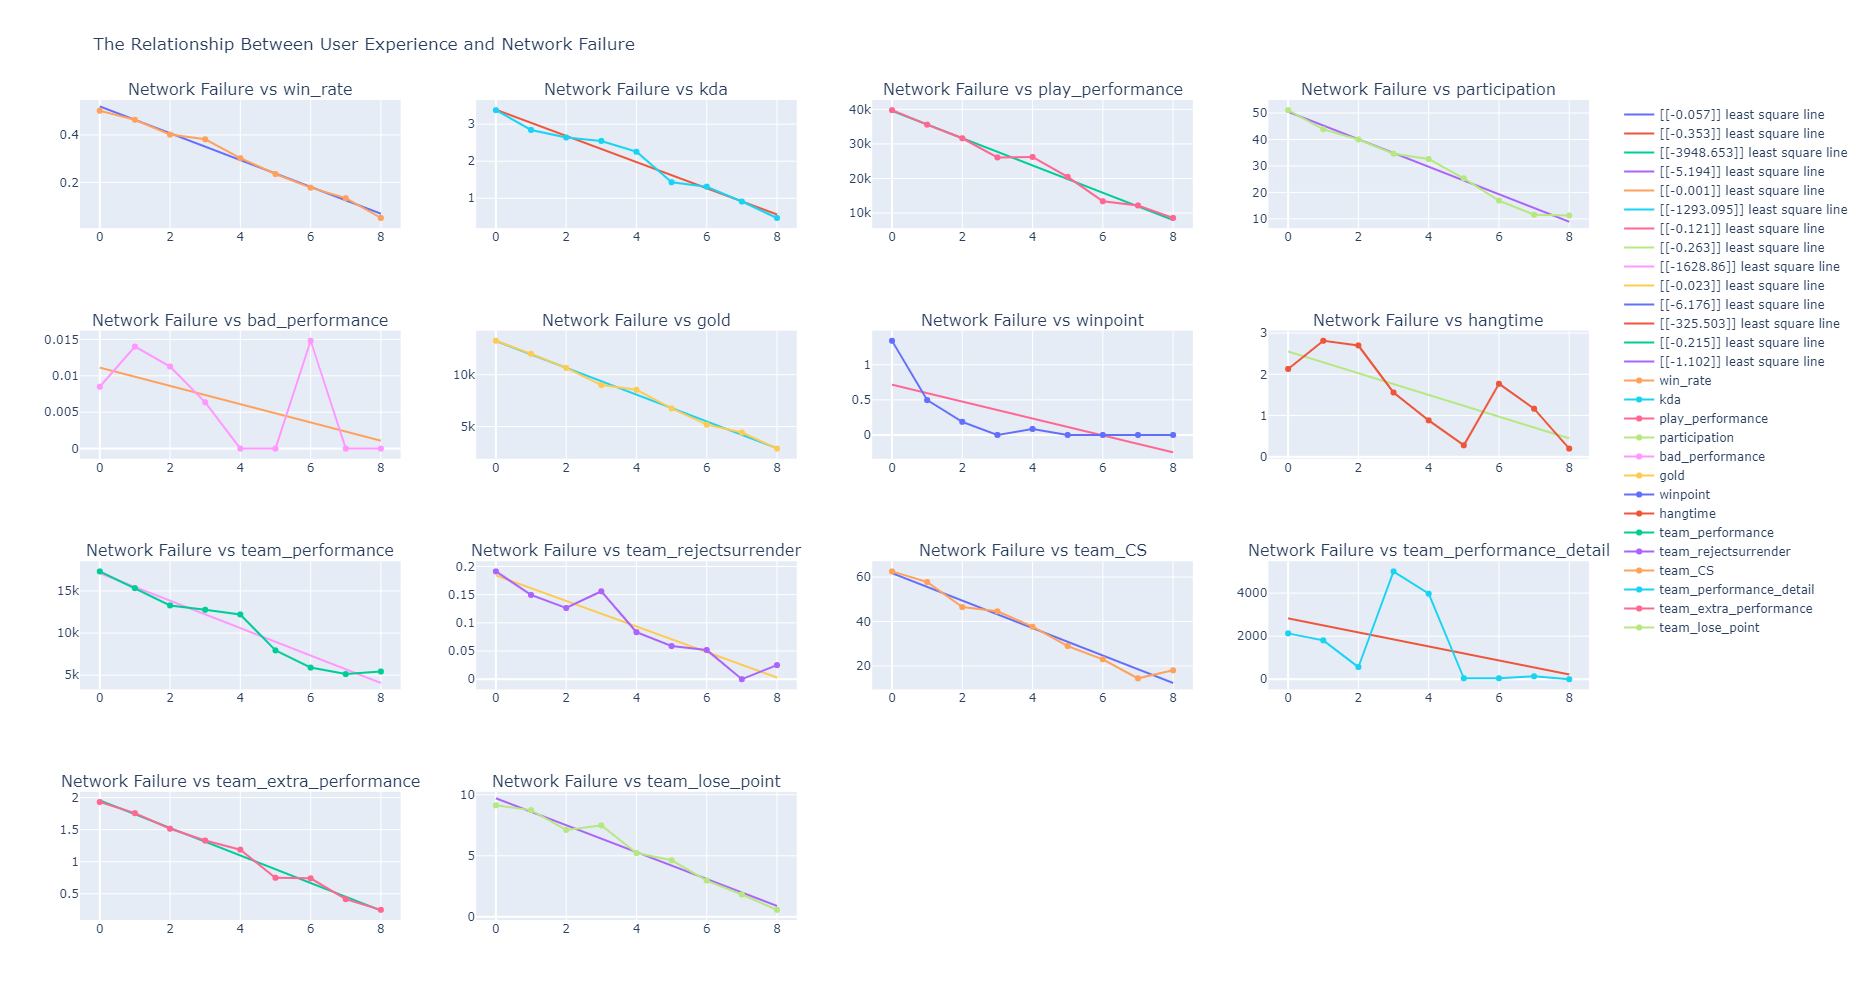

'\n分析与假设一之间的关系\n1.总体上：随着掉线次数的增加，个人玩家和团队体验逐渐变得不佳；\n2.玩家个人失败概率将逐渐增大,始终小于50%。其他指标如kda，个人战绩，个人参团率，个人获得金币量，个人胜利点都在平稳下降\n3.从团队的视角来看，补兵数量，击杀敌人数量，击杀大小龙数量和团队点数随着断线次数增加而下降\n\n问题：bad_performance和hangtime出现类似性，但在6-7处于最低值，不符合线段一直上升的假象趋势\n     team_performance_detail(塔/怪)指数波动比较明显，在4/6出现较高异常值\n'

In [28]:
uexper_np = make_subplots(rows=4, cols=4,subplot_titles=(c_net_selfteam_list(0)))

def uexp_n (w,m,k,r,c):
    return uexper_np.add_trace(go.Scatter(x=no_i(w),y=c_net_selfteam_mean(m)[c_net_selfteam_index(k)],name=c_net_selfteam_index(k),mode='lines'),row=r, col=c)

def leastsquare_n(m,k,r,c):
    x_data=c_net_selfteam_mean(m)[c_net_selfteam_index(k)].index.values[:,np.newaxis]
    y_data=c_net_selfteam_mean(m)[c_net_selfteam_index(k)].values[:,np.newaxis]
    reg=LinearRegression().fit(x_data,y_data)
    reg_coef=str(reg.coef_.round(3))
    reg_predict=reg.predict(x_data).flatten()
    return uexper_np.add_trace(go.Scatter(x=x_data.flatten(),y=reg_predict,name=reg_coef+' least square line',mode='lines+markers'),row=r, col=c)

leastsquare_n(0,0,1,1)
leastsquare_n(0,1,1,2)
leastsquare_n(0,2,1,3)
leastsquare_n(0,3,1,4)
leastsquare_n(0,4,2,1)
leastsquare_n(0,5,2,2)
leastsquare_n(0,6,2,3)
leastsquare_n(0,7,2,4)
leastsquare_n(1,8,3,1)
leastsquare_n(1,9,3,2)
leastsquare_n(1,10,3,3)
leastsquare_n(1,11,3,4)
leastsquare_n(1,12,4,1)
leastsquare_n(1,13,4,2)

uexp_n(0,0,0,1,1)
uexp_n(0,0,1,1,2)
uexp_n(0,0,2,1,3)
uexp_n(0,0,3,1,4)
uexp_n(0,0,4,2,1)
uexp_n(0,0,5,2,2)
uexp_n(0,0,6,2,3)
uexp_n(0,0,7,2,4)
uexp_n(0,1,8,3,1)
uexp_n(0,1,9,3,2)
uexp_n(0,1,10,3,3)
uexp_n(0,1,11,3,4)
uexp_n(0,1,12,4,1)
uexp_n(0,1,13,4,2)

uexper_np=uexper_np.update_layout(height=1000, title_text="The Relationship Between User Experience and Network Failure")
uexper_np.show()

'''
分析与假设一之间的关系
1.总体上：随着掉线次数的增加，个人玩家和团队体验逐渐变得不佳；
2.玩家个人失败概率将逐渐增大,始终小于50%。其他指标如kda，个人战绩，个人参团率，个人获得金币量，个人胜利点都在平稳下降
3.从团队的视角来看，补兵数量，击杀敌人数量，击杀大小龙数量和团队点数随着断线次数增加而下降

问题：bad_performance和hangtime出现类似性，但在6-7处于最低值，不符合线段一直上升的假象趋势
     team_performance_detail(塔/怪)指数波动比较明显，在4/6出现较高异常值
'''

In [29]:
#关于操作卡顿次数的统计
operation_index=data.operation_failure.value_counts(sort=True).sort_index().index
operation_roomresult=data['roomresult'].groupby(data.operation_failure).value_counts(dropna=True)
operation_failure=pd.DataFrame(operation_roomresult).rename(columns={'roomresult':'values'}).reset_index()

win_o=operation_failure.loc[operation_failure['roomresult']=='Win']
lose_o=operation_failure.loc[operation_failure['roomresult']=='Lose']

operation_winlose=win_o.merge(lose_o,how='left',left_on=win_o['operation_failure'],right_on=lose_o['operation_failure'])
operation_win_rate=(operation_winlose['values_x']/(operation_winlose['values_y']+operation_winlose['values_x'])).round(5).dropna()

weight=pd.DataFrame(np.arange(len(operation_win_rate)/100,0.01,-0.01))
#定义network_team里每个值的加权平均数
operation_self_mea=pd.concat([data.loc[:,'kda':'hangtime'].groupby(data.operation_failure).mean(),weight], axis=1,ignore_index=False).rename(columns={0: 'weight'}).dropna()
operation_self_median=pd.concat([data.loc[:,'kda':'hangtime'].groupby(data.operation_failure).median(),weight], axis=1,ignore_index=False).rename(columns={0: 'weight'}).dropna()
operation_self_mean=pd.concat([operation_win_rate,(operation_self_mea+operation_self_median)/2],axis=1,ignore_index=False).multiply(operation_self_mea.weight, axis="index").rename(columns={0: 'win_rate'}).dropna()

operation_team_mea=pd.concat([data.loc[:,'team_performance':'team_lose_point'].groupby(data.operation_failure).mean(),weight], axis=1,ignore_index=False).rename(columns={0: 'weight'}).dropna()
operation_team_median=pd.concat([data.loc[:,'team_performance':'team_lose_point'].groupby(data.operation_failure).median(),weight], axis=1,ignore_index=False).rename(columns={0: 'weight'}).dropna()
operation_team_mean=pd.concat([operation_win_rate,(operation_team_mea+operation_team_median)/2],axis=1,ignore_index=False).multiply(operation_team_mea.weight, axis="index").rename(columns={0: 'win_rate'}).dropna()

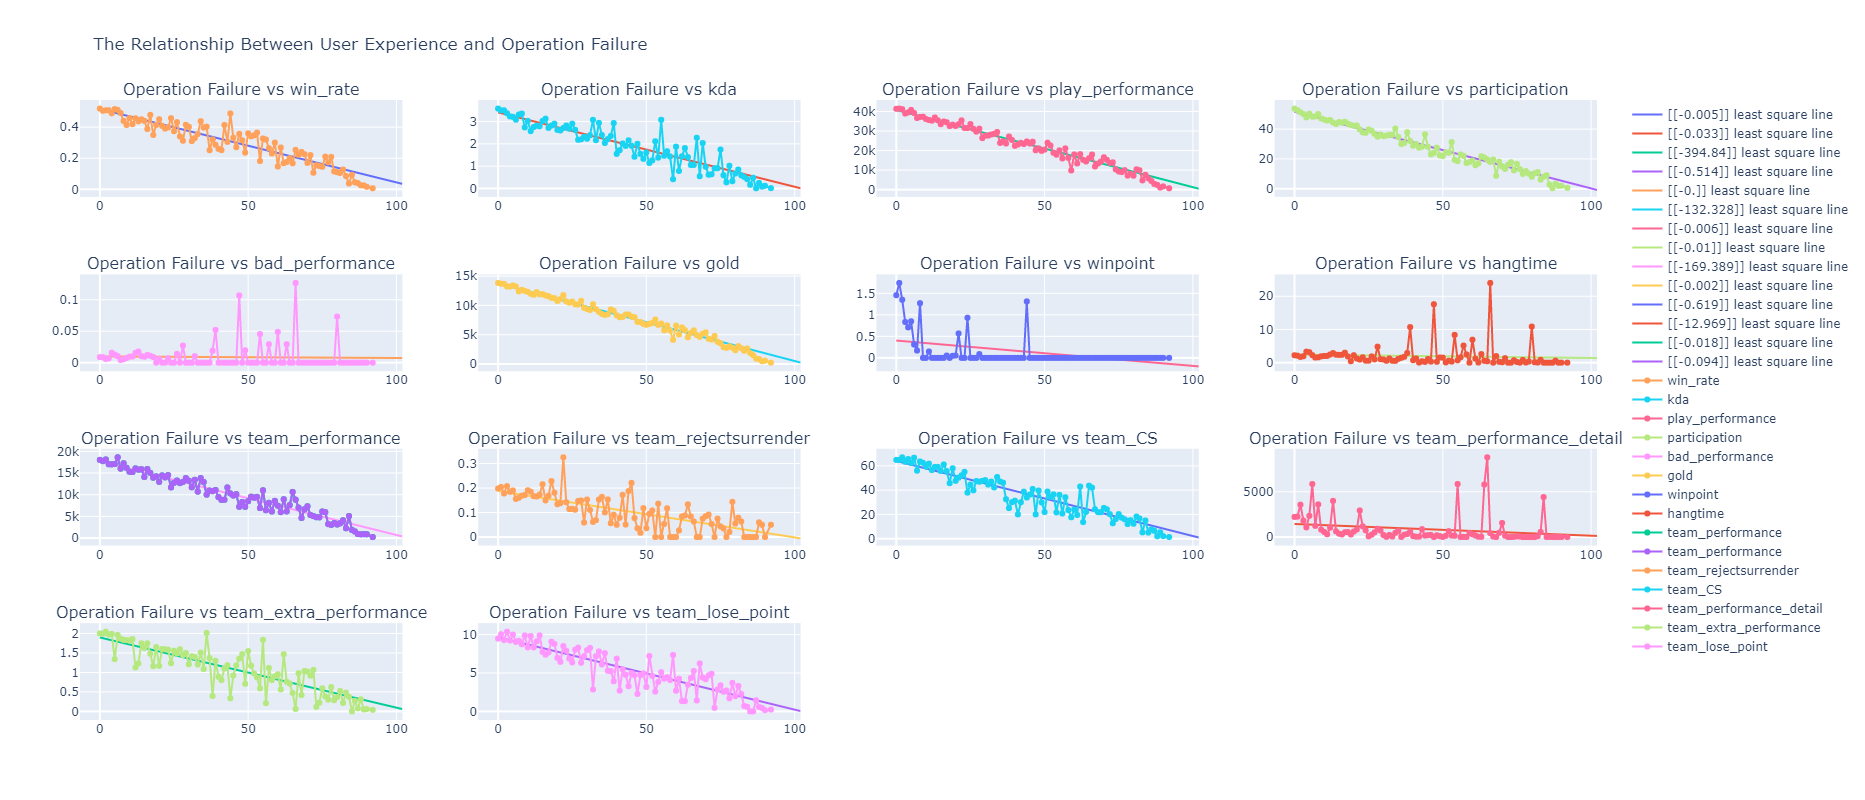

'\n出现的现象类似与断线影响\n'

In [30]:
# 绘制可视化图片验证猜想
opr_selfteam_index=pd.concat([pd.concat([operation_win_rate,data.loc[:,'kda':'hangtime']],axis=1,ignore_index=False).rename(columns={0: 'win_rate'}),data.loc[:,'team_performance':'team_lose_point']],axis=1,ignore_index=False).columns
opr_selfteam_list=opr_selfteam_index.values.tolist()

def c_opr_selfteam_mean(m):
    opr_selfteam_mean_list=[operation_self_mean,operation_team_mean]
    return opr_selfteam_mean_list[m]

notice_line=np.ones(len(operation_win_rate)-10)/2

def c_opr_selfteam_index(k):
    return opr_selfteam_index[k]

def c_opr_selfteam_list(p):
    self_team=[]
    for names in opr_selfteam_list:
        answer=c_netope_list(p)+' '+'vs'+' '+names
        self_team.append(answer)
    return self_team

def uexp_o (w,m,k,r,c):
    return uexper_np.add_trace(go.Scatter(x=no_i(w),y=c_opr_selfteam_mean(m)[c_opr_selfteam_index(k)],name=c_opr_selfteam_index(k),mode='lines+markers'),row=r, col=c)

def leastsquare_o(m,k,r,c):
    x_data=c_opr_selfteam_mean(m)[c_opr_selfteam_index(k)].index.values[:,np.newaxis]
    y_data=c_opr_selfteam_mean(m)[c_opr_selfteam_index(k)].values[:,np.newaxis]
    reg=LinearRegression().fit(x_data,y_data)
    reg_coef=str(reg.coef_.round(3))
    reg_predict=reg.predict(x_data).flatten()
    return uexper_np.add_trace(go.Scatter(x=x_data.flatten(),y=reg_predict,name=reg_coef+' least square line',mode='lines'),row=r, col=c)

uexper_np = make_subplots(rows=4, cols=4,subplot_titles=(c_net_selfteam_list(1)))

leastsquare_o(0,0,1,1)
leastsquare_o(0,1,1,2)
leastsquare_o(0,2,1,3)
leastsquare_o(0,3,1,4)
leastsquare_o(0,4,2,1)
leastsquare_o(0,5,2,2)
leastsquare_o(0,6,2,3)
leastsquare_o(0,7,2,4)
leastsquare_o(1,8,3,1)
leastsquare_o(1,9,3,2)
leastsquare_o(1,10,3,3)
leastsquare_o(1,11,3,4)
leastsquare_o(1,12,4,1)
leastsquare_o(1,13,4,2)

uexp_o(1,0,0,1,1)
uexp_o(1,0,1,1,2)
uexp_o(1,0,2,1,3)
uexp_o(1,0,3,1,4)
uexp_o(1,0,4,2,1)
uexp_o(1,0,5,2,2)
uexp_o(1,0,6,2,3)
uexp_o(1,0,7,2,4)
uexp_o(1,1,8,3,1)
uexp_o(1,1,8,3,1)
uexp_o(1,1,9,3,2)
uexp_o(1,1,10,3,3)
uexp_o(1,1,11,3,4)
uexp_o(1,1,12,4,1)
uexp_o(1,1,13,4,2)

uexper_np=uexper_np.update_layout(height=800, title_text="The Relationship Between User Experience and Operation Failure")
uexper_np.show()

'''
出现的现象类似与断线影响
'''

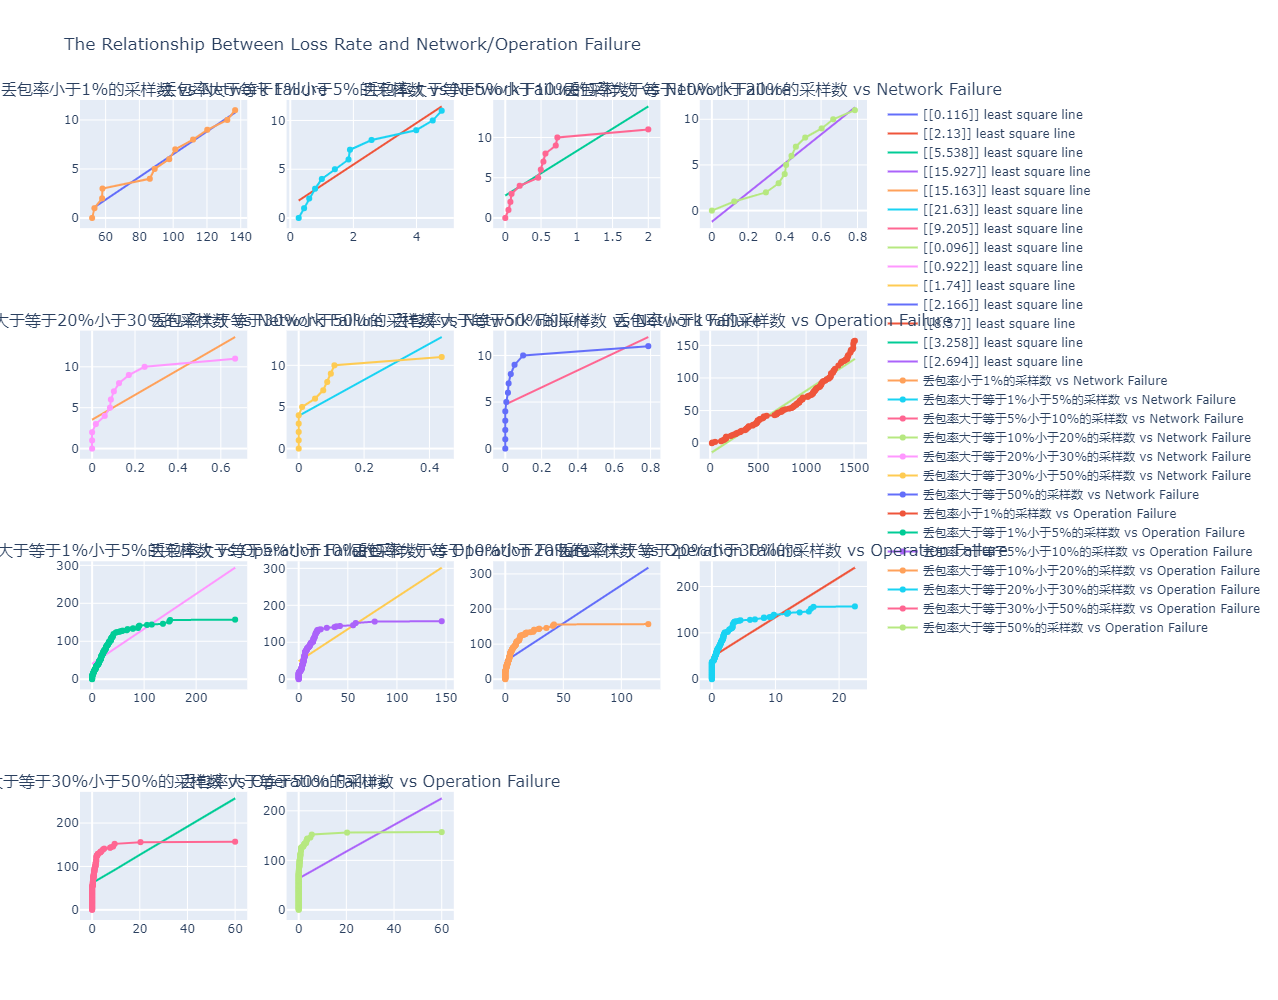

In [31]:
data_loss=data.loc[:,'lossRate1':'lossRate7']

# data_loss groupby network 
network_loss_mean=data_loss.groupby(data.network_failure).mean()
weight=pd.DataFrame(np.arange(len(network_loss_mean)/10,0.1,-0.1))
network_loss_mea=pd.concat([network_loss_mean,weight],axis=1, ignore_index=False).rename(columns={0: 'weight'}).dropna()
network_loss_median=pd.concat([data_loss.groupby(data.network_failure).median(),weight],axis=1, ignore_index=False).rename(columns={0: 'weight'}).dropna()
network_loss_mean=((network_loss_mea+network_loss_median)/2).multiply(network_loss_mea.weight, axis="index").rename(columns={0: 'weight'}).dropna()

# data_loss groupby operation
operation_loss_mean=data_loss.groupby(data.operation_failure).mean()
weight=pd.DataFrame(np.arange(len(operation_loss_mean)/10,0.1,-0.1))
operation_loss_mea=pd.concat([operation_loss_mean,weight],axis=1, ignore_index=False).rename(columns={0: 'weight'}).dropna()
operation_loss_median=pd.concat([data_loss.groupby(data.operation_failure).median(),weight],axis=1, ignore_index=False).rename(columns={0: 'weight'}).dropna()
operation_loss_mean=((operation_loss_mea+operation_loss_median)/2).multiply(operation_loss_mea.weight, axis="index").rename(columns={0: 'weight'}).dropna()

data_loss_index=data_loss.columns
data_loss_list=data_loss_index.values.tolist()
loss_name=['丢包率小于1%的采样数','丢包率大于等于1%小于5%的采样数','丢包率大于等于5%小于10%的采样数','丢包率大于等于10%小于20%的采样数','丢包率大于等于20%小于30%的采样数','丢包率大于等于30%小于50%的采样数','丢包率大于等于50%的采样数']

#network failure vs loss rate
def c_loss_mean(m):
    loss_mean=[network_loss_mean,operation_loss_mean]
    return loss_mean[m]

def c_loss_index(n):
    return data_loss_index[n]

def c_name_loss_con(p,k):
    lossname=[]     
    for zh_names in loss_name:
        answer=zh_names+' vs '+ c_netope_list(p)
        lossname.append(answer)
    return lossname[k]

net_lossname=[]
for zh_names in loss_name:
    answer=zh_names + ' vs '+ c_netope_list(0)
    net_lossname.append(answer)

opr_lossname=[]
for zh_names in loss_name:
    answer=zh_names + ' vs '+ c_netope_list(1) 
    opr_lossname.append(answer)

lossname=net_lossname+opr_lossname

def loss_no(m,n,w,p,k,r,c):
    return lossno.add_trace(go.Scatter(x=c_loss_mean(m)[c_loss_index(n)].sort_values(),y=no_i(w),name=c_name_loss_con(p,k),mode='lines+markers'),row=r,col=c)

def leastsquare_loss(m,n,w,r,c):
    x_data=c_loss_mean(m)[c_loss_index(n)].sort_values().values[:,np.newaxis]
    y_data=c_loss_mean(m)[c_loss_index(n)].index.values[:,np.newaxis]

    reg=LinearRegression().fit(x_data,y_data)
    reg_coef=str(reg.coef_.round(3))
    reg_predict=reg.predict(x_data).flatten()
    return lossno.add_trace(go.Scatter(x=x_data.flatten(),y=reg_predict,name=reg_coef+' least square line',mode='lines'),row=r, col=c)


lossno = make_subplots(rows=4, cols=4,subplot_titles=(lossname))
leastsquare_loss(0,0,0,1,1)
leastsquare_loss(0,1,0,1,2)
leastsquare_loss(0,2,0,1,3)
leastsquare_loss(0,3,0,1,4)
leastsquare_loss(0,4,0,2,1)
leastsquare_loss(0,5,0,2,2)
leastsquare_loss(0,6,0,2,3)

leastsquare_loss(1,0,1,2,4)
leastsquare_loss(1,1,1,3,1)
leastsquare_loss(1,2,1,3,2)
leastsquare_loss(1,3,1,3,3)
leastsquare_loss(1,4,1,3,4)
leastsquare_loss(1,5,1,4,1)
leastsquare_loss(1,6,1,4,2)

loss_no(0,0,0,0,0,1,1)
loss_no(0,1,0,0,1,1,2)
loss_no(0,2,0,0,2,1,3)
loss_no(0,3,0,0,3,1,4)
loss_no(0,4,0,0,4,2,1)
loss_no(0,5,0,0,5,2,2)
loss_no(0,6,0,0,6,2,3)

loss_no(1,0,1,1,0,2,4)
loss_no(1,1,1,1,1,3,1)
loss_no(1,2,1,1,2,3,2)
loss_no(1,3,1,1,3,3,3)
loss_no(1,4,1,1,4,3,4)
loss_no(1,5,1,1,5,4,1)
loss_no(1,6,1,1,6,4,2)

lossno=lossno.update_layout(height=1000, title_text="The Relationship Between Loss Rate and Network/Operation Failure")
lossno.show()

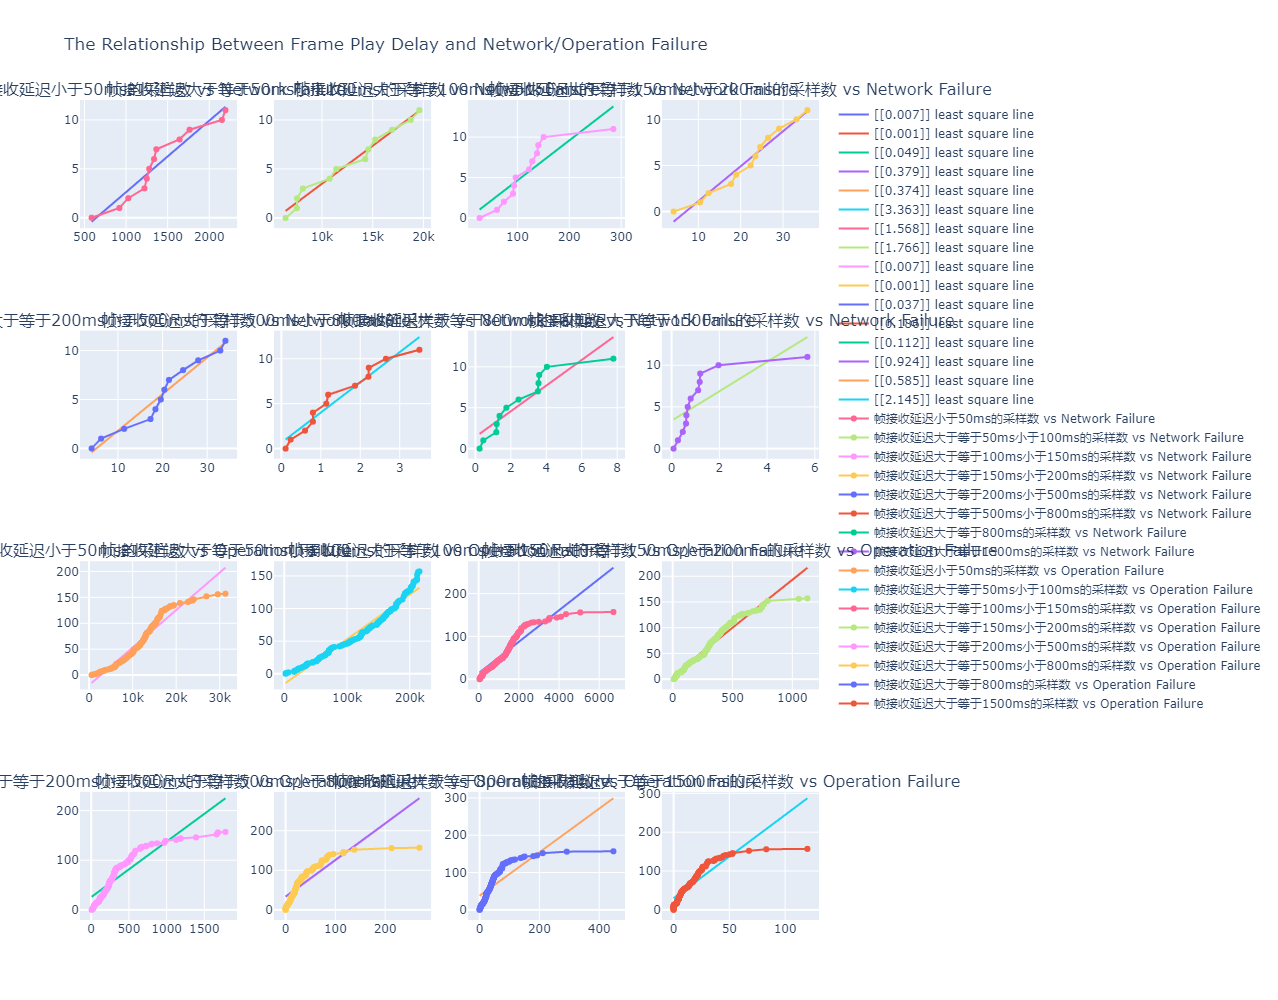

In [32]:
data_framePlayDelay=data.loc[:,'framePlayDelay1':'framePlayDelay8']
# data_framePlayDelay groupby network 
network_framePlayDelay_mean=data_framePlayDelay.groupby(data.network_failure).mean()
weight=pd.DataFrame(np.arange(len(network_framePlayDelay_mean)/10,0.1,-0.1))
network_framePlayDelay_mea=pd.concat([network_framePlayDelay_mean,weight],axis=1, ignore_index=False).rename(columns={0: 'weight'}).dropna()
network_framePlayDelay_median=pd.concat([data_framePlayDelay.groupby(data.network_failure).median(),weight],axis=1, ignore_index=False).rename(columns={0: 'weight'}).dropna()
network_framePlayDelay_mean=((network_framePlayDelay_mea+network_framePlayDelay_median)/2).multiply(network_framePlayDelay_mea.weight, axis="index").rename(columns={0: 'weight'}).dropna()

# data_framePlayDelay groupby operation
operation_framePlayDelay_mean=data_framePlayDelay.groupby(data.operation_failure).mean()
weight=pd.DataFrame(np.arange(len(operation_framePlayDelay_mean)/10,0.1,-0.1))
operation_framePlayDelay_mea=pd.concat([operation_framePlayDelay_mean,weight],axis=1, ignore_index=False).rename(columns={0: 'weight'}).dropna()
operation_framePlayDelay_median=pd.concat([data_framePlayDelay.groupby(data.operation_failure).median(),weight],axis=1, ignore_index=False).rename(columns={0: 'weight'}).dropna()
operation_framePlayDelay_mean=((operation_framePlayDelay_mea+operation_framePlayDelay_median)/2).multiply(operation_framePlayDelay_mea.weight, axis="index").rename(columns={0: 'weight'}).dropna()

data_framePlayDelay_index=data_framePlayDelay.columns
data_framePlayDelay_list=data_framePlayDelay_index.values.tolist()
framePlayDelay_name=['帧接收延迟小于50ms的采样数','帧接收延迟大于等于50ms小于100ms的采样数','帧接收延迟大于等于100ms小于150ms的采样数','帧接收延迟大于等于150ms小于200ms的采样数','帧接收延迟大于等于200ms小于500ms的采样数','帧接收延迟大于等于500ms小于800ms的采样数','帧接收延迟大于等于800ms的采样数','帧接收延迟大于等于1500ms的采样数']
#network failure vs framePlayDelay rate
def c_framePlayDelay_mean(m):
    framePlayDelay_mean=[network_framePlayDelay_mean,operation_framePlayDelay_mean]
    return framePlayDelay_mean[m]

def c_framePlayDelay_index(n):
    return data_framePlayDelay_index[n]

def c_name_framePlayDelay_con(p,k):
    framePlayDelayname=[]     
    for zh_names in framePlayDelay_name:
        answer=zh_names+' vs '+ c_netope_list(p)
        framePlayDelayname.append(answer)
    return framePlayDelayname[k]

net_framePlayDelayname=[]
for zh_names in framePlayDelay_name:
    answer=zh_names + ' vs '+c_netope_list(0) 
    net_framePlayDelayname.append(answer)

opr_framePlayDelayname=[]
for zh_names in framePlayDelay_name:
    answer=zh_names + ' vs '+ c_netope_list(1) 
    opr_framePlayDelayname.append(answer)

framePlayDelayname=net_framePlayDelayname+opr_framePlayDelayname

def framePlayDelay_no(m,n,w,p,k,r,c):
    return framePlayDelayno.add_trace(go.Scatter(x=c_framePlayDelay_mean(m)[c_framePlayDelay_index(n)].sort_values(),y=no_i(w),name=c_name_framePlayDelay_con(p,k),mode='lines+markers'),row=r,col=c)

def leastsquare_framePlayDelay(m,n,w,r,c):
    x_data=c_framePlayDelay_mean(m)[c_framePlayDelay_index(n)].sort_values().values[:,np.newaxis]
    y_data=c_framePlayDelay_mean(m)[c_framePlayDelay_index(n)].index.values[:,np.newaxis]

    reg=LinearRegression().fit(x_data,y_data)
    reg_coef=str(reg.coef_.round(3))
    reg_predict=reg.predict(x_data).flatten()
    return framePlayDelayno.add_trace(go.Scatter(x=x_data.flatten(),y=reg_predict,name=reg_coef+' least square line',mode='lines'),row=r, col=c)

framePlayDelayno = make_subplots(rows=4, cols=4, subplot_titles=(framePlayDelayname))

leastsquare_framePlayDelay(0,0,0,1,1)
leastsquare_framePlayDelay(0,1,0,1,2)
leastsquare_framePlayDelay(0,2,0,1,3)
leastsquare_framePlayDelay(0,3,0,1,4)
leastsquare_framePlayDelay(0,4,0,2,1)
leastsquare_framePlayDelay(0,5,0,2,2)
leastsquare_framePlayDelay(0,6,0,2,3)
leastsquare_framePlayDelay(0,7,0,2,4)

leastsquare_framePlayDelay(1,0,1,3,1)
leastsquare_framePlayDelay(1,1,1,3,2)
leastsquare_framePlayDelay(1,2,1,3,3)
leastsquare_framePlayDelay(1,3,1,3,4)
leastsquare_framePlayDelay(1,4,1,4,1)
leastsquare_framePlayDelay(1,5,1,4,2)
leastsquare_framePlayDelay(1,6,1,4,3)
leastsquare_framePlayDelay(1,7,1,4,4)

framePlayDelay_no(0,0,0,0,0,1,1)
framePlayDelay_no(0,1,0,0,1,1,2)
framePlayDelay_no(0,2,0,0,2,1,3)
framePlayDelay_no(0,3,0,0,3,1,4)
framePlayDelay_no(0,4,0,0,4,2,1)
framePlayDelay_no(0,5,0,0,5,2,2)
framePlayDelay_no(0,6,0,0,6,2,3)
framePlayDelay_no(0,7,0,0,7,2,4)

framePlayDelay_no(1,0,1,1,0,3,1)
framePlayDelay_no(1,1,1,1,1,3,2)
framePlayDelay_no(1,2,1,1,2,3,3)
framePlayDelay_no(1,3,1,1,3,3,4)
framePlayDelay_no(1,4,1,1,4,4,1)
framePlayDelay_no(1,5,1,1,5,4,2)
framePlayDelay_no(1,6,1,1,6,4,3)
framePlayDelay_no(1,7,1,1,7,4,4)

framePlayDelayno=framePlayDelayno.update_layout(height=1000, title_text="The Relationship Between Frame Play Delay and Network/Operation Failure")
framePlayDelayno.show()

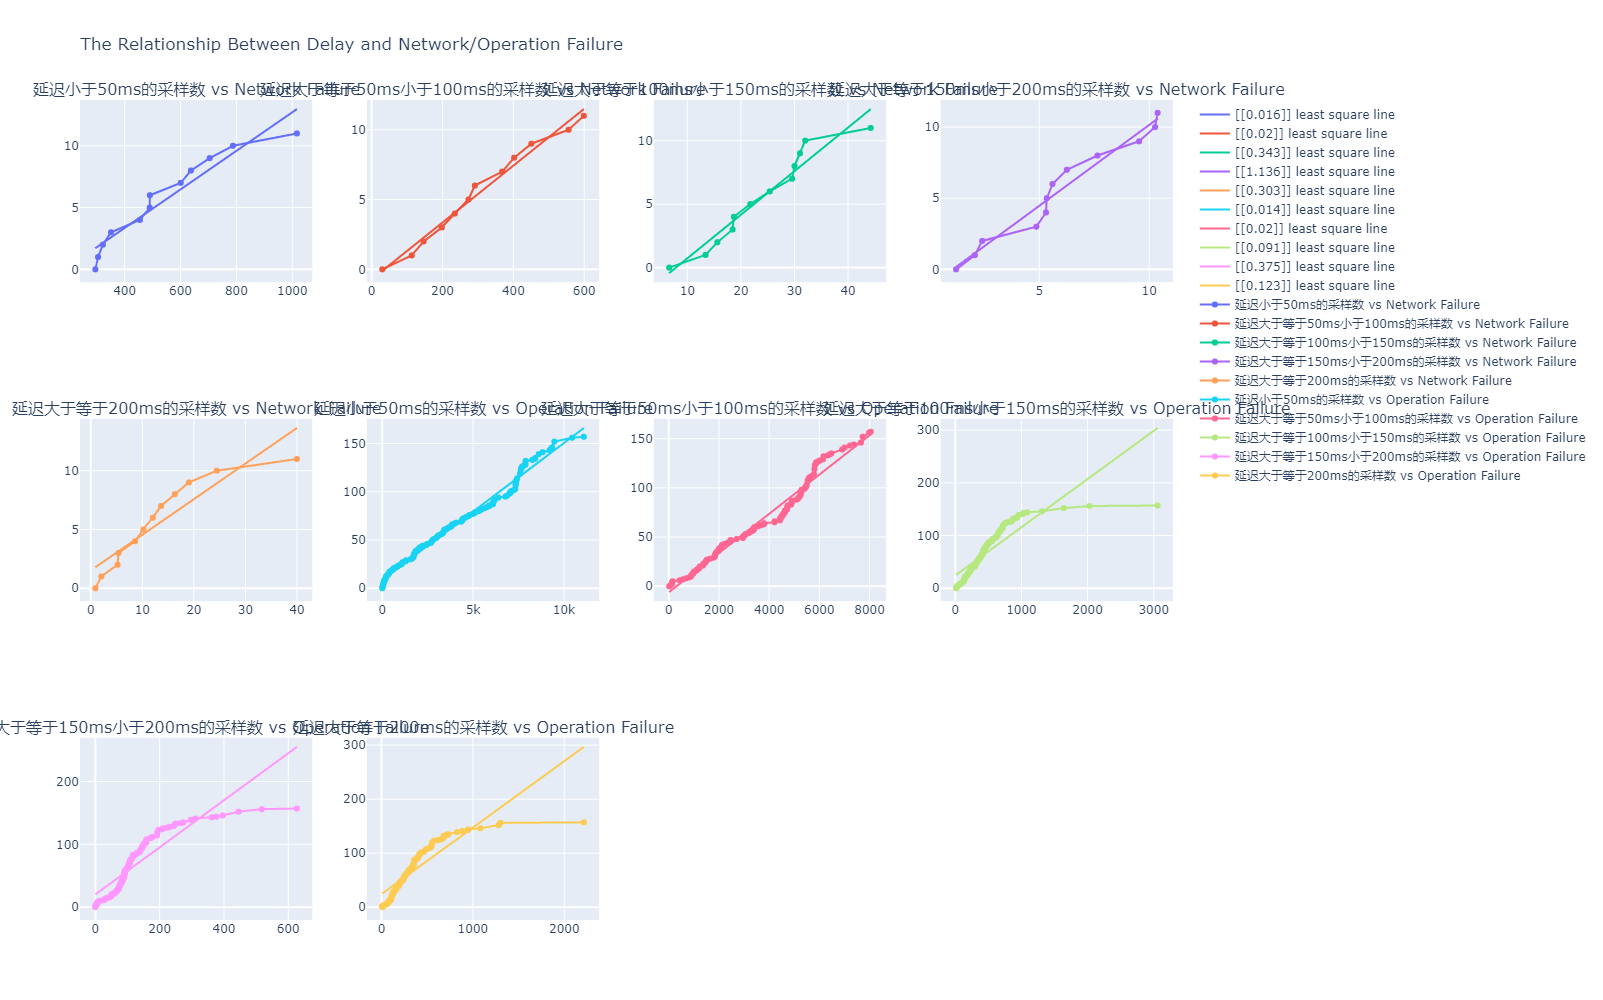

In [33]:
data_delay=data.loc[:,'delay1':'delay5']
# data_delay groupby network 
network_delay_mean=data_delay.groupby(data.network_failure).mean()
weight=pd.DataFrame(np.arange(len(network_delay_mean)/10,0.1,-0.1))
network_delay_mea=pd.concat([network_delay_mean,weight],axis=1, ignore_index=False).rename(columns={0: 'weight'}).dropna()
network_delay_median=pd.concat([data_delay.groupby(data.network_failure).median(),weight],axis=1, ignore_index=False).rename(columns={0: 'weight'}).dropna()
network_delay_mean=((network_delay_mea+network_delay_median)/2).multiply(network_delay_mea.weight, axis="index").rename(columns={0: 'weight'}).dropna()

# data_delay groupby operation
operation_delay_mean=data_delay.groupby(data.operation_failure).mean()
weight=pd.DataFrame(np.arange(len(operation_delay_mean)/10,0.1,-0.1))
operation_delay_mea=pd.concat([operation_delay_mean,weight],axis=1, ignore_index=False).rename(columns={0: 'weight'}).dropna()
operation_delay_median=pd.concat([data_delay.groupby(data.operation_failure).median(),weight],axis=1, ignore_index=False).rename(columns={0: 'weight'}).dropna()
operation_delay_mean=((operation_delay_mea+operation_delay_median)/2).multiply(operation_delay_mea.weight, axis="index").rename(columns={0: 'weight'}).dropna()

data_delay_index=data_delay.columns
data_delay_list=data_delay_index.values.tolist()
delay_name=['延迟小于50ms的采样数','延迟大于等于50ms小于100ms的采样数','延迟大于等于100ms小于150ms的采样数','延迟大于等于150ms小于200ms的采样数','延迟大于等于200ms的采样数']
#network failure vs delay rate
def c_delay_mean(m):
    delay_mean=[network_delay_mean,operation_delay_mean]
    return delay_mean[m]

def c_delay_index(n):
    return data_delay_index[n]

def c_name_delay_con(p,k):
    delayname=[]     
    for zh_names in delay_name:
        answer=zh_names+' vs '+ c_netope_list(p)
        delayname.append(answer)
    return delayname[k]

net_delayname=[]
for zh_names in delay_name:
    answer=zh_names + ' vs '+c_netope_list(0) 
    net_delayname.append(answer)

opr_delayname=[]
for zh_names in delay_name:
    answer=zh_names + ' vs '+ c_netope_list(1) 
    opr_delayname.append(answer)

delayname=net_delayname+opr_delayname

def delay_no(m,n,w,p,k,r,c):
    return delayno.add_trace(go.Scatter(x=c_delay_mean(m)[c_delay_index(n)].sort_values(),y=no_i(w),name=c_name_delay_con(p,k),mode='lines+markers'),row=r,col=c)

def leastsquare_delay(m,n,w,r,c):
    x_data=c_delay_mean(m)[c_delay_index(n)].sort_values().values[:,np.newaxis]
    y_data=c_delay_mean(m)[c_delay_index(n)].index.values[:,np.newaxis]

    reg=LinearRegression().fit(x_data,y_data)
    reg_coef=str(reg.coef_.round(3))
    reg_predict=reg.predict(x_data).flatten()
    return delayno.add_trace(go.Scatter(x=x_data.flatten(),y=reg_predict,name=reg_coef+' least square line',mode='lines'),row=r, col=c)

delayno = make_subplots(rows=3, cols=4, subplot_titles=(delayname))

leastsquare_delay(0,0,0,1,1)
leastsquare_delay(0,1,0,1,2)
leastsquare_delay(0,2,0,1,3)
leastsquare_delay(0,3,0,1,4)
leastsquare_delay(0,4,0,2,1)

leastsquare_delay(1,0,1,2,2)
leastsquare_delay(1,1,1,2,3)
leastsquare_delay(1,2,1,2,4)
leastsquare_delay(1,3,1,3,1)
leastsquare_delay(1,4,1,3,2)

delay_no(0,0,0,0,0,1,1)
delay_no(0,1,0,0,1,1,2)
delay_no(0,2,0,0,2,1,3)
delay_no(0,3,0,0,3,1,4)
delay_no(0,4,0,0,4,2,1)

delay_no(1,0,1,1,0,2,2)
delay_no(1,1,1,1,1,2,3)
delay_no(1,2,1,1,2,2,4)
delay_no(1,3,1,1,3,3,1)
delay_no(1,4,1,1,4,3,2)

delayno=delayno.update_layout(height=1000, title_text="The Relationship Between Delay and Network/Operation Failure")
delayno.show()

In [232]:
sql_on_tcp=('''
with pre as(
select
b.timeoutNetworkFailCount+b.peerCloseConnectionNetworkFailCount+b.networkTypeChangeNetworkFailCount+b.backgroundNetworkFailCount+b.exceptionNetworkFailCount as network_failure,
b.pullTimeCount+b.inconsistentDirCount+b.inconsistentPosCount+b.operationDelayCount+b.skillOperationDelayCount+b.skillOperationLostCount as operation_failure,

b.lossRate4+b.lossRate5+b.lossRate6+b.lossRate7 as lossrate,
b.framePlayDelay5+b.framePlayDelay6+b.framePlayDelay7+b.framePlayDelay8 as FRD,
b.delay3+b.delay4+b.delay5 as delay,

b.dtEventTime,

case
when cast(b.RoleID as bigint)%10000 >= 5000 and cast(b.RoleID as bigint)%10000 < 5100 and b.dtEventTime>='2021-08-05 15:30:00' and b.dtEventTime<'2021-08-12 14:20:00' 
and cast(c.RoleID as bigint)%10000 >= 5000 and cast(c.RoleID as bigint)%10000 < 5100 and c.dtEventTime>='2021-08-05 15:30:00' and c.dtEventTime<'2021-08-12 14:20:00' then 'test_group'
when cast(b.RoleID as bigint)%10000 >= 5000 and cast(b.RoleID as bigint)%10000 < 6000 and b.dtEventTime>='2021-08-12 14:20:00' and b.dtEventTime<'2021-08-19 15:00:00' 
and cast(c.RoleID as bigint)%10000 >= 5000 and cast(c.RoleID as bigint)%10000 < 5100 and c.dtEventTime>='2021-08-05 15:30:00' and c.dtEventTime<'2021-08-12 14:20:00' then 'test_group'
when cast(b.RoleID as bigint)%10000 >= 7000 and cast(b.RoleID as bigint)%10000 < 9000 and b.dtEventTime>='2021-08-19 15:00:00' and b.dtEventTime<'2021-08-25 10:20:00' 
and cast(c.RoleID as bigint)%10000 >= 7000 and cast(c.RoleID as bigint)%10000 < 9000 and c.dtEventTime>='2021-08-19 15:00:00' and c.dtEventTime<'2021-08-25 10:20:00' then 'test_group'

else 'reference_group' end as user_classification,

case 
when c.s_tcpSupplyFrameCount>0 or c.s_tcpSupplyFramePckCnt>0 then 'tcpY'
else 'tcpN' end as tcpYN

from 100375_stutter_staging as b
join 100375_tdm_10s_battle_stage as c
on b.vopenid=c.vopenid and b.dtEventTime=c.dtEventTime

where
b.dtEventTime>='2021-08-05 15:30:00' AND b.dtEventTime<='2021-08-25 10:20:00' 
AND
c.dtEventTime>='2021-08-05 15:30:00' AND c.dtEventTime<='2021-08-25 10:20:00')

select 
(avg(network_failure)+approx_percentile(network_failure,0.5))/2 as network_failure,
(avg(operation_failure)+approx_percentile(operation_failure,0.5))/2 as operation_failure,
(avg(lossrate)+approx_percentile(network_failure,0.5))/2 as lossrate,
(avg(FRD)+approx_percentile(FRD,0.5))/2 as FRD,
(avg(delay)+approx_percentile(delay,0.5))/2 as delay, user_classification,tcpYN,dtEventTime

from pre
group by dtEventTime,user_classification,tcpYN
order by dtEventTime,user_classification,tcpYN
''')
data=get_data(sql_on_tcp)

In [234]:
#研究重点
#operation_failure,network_failure的严重情况
#lossRate from 10 to over 50
#framePlayDelay from 200 to over 1500
#delay from 100 to over 200
data.dtEventTime=pd.to_datetime(data.dtEventTime,errors='ignore',format='%Y%m%d')
#区分特征用户组和非特征用户组
target=data[data.user_classification=='test_group']
target_Y=target[target.tcpYN=='tcpY']
target_N=target[target.tcpYN=='tcpN']
nontarget=data[data.user_classification=='reference_group']

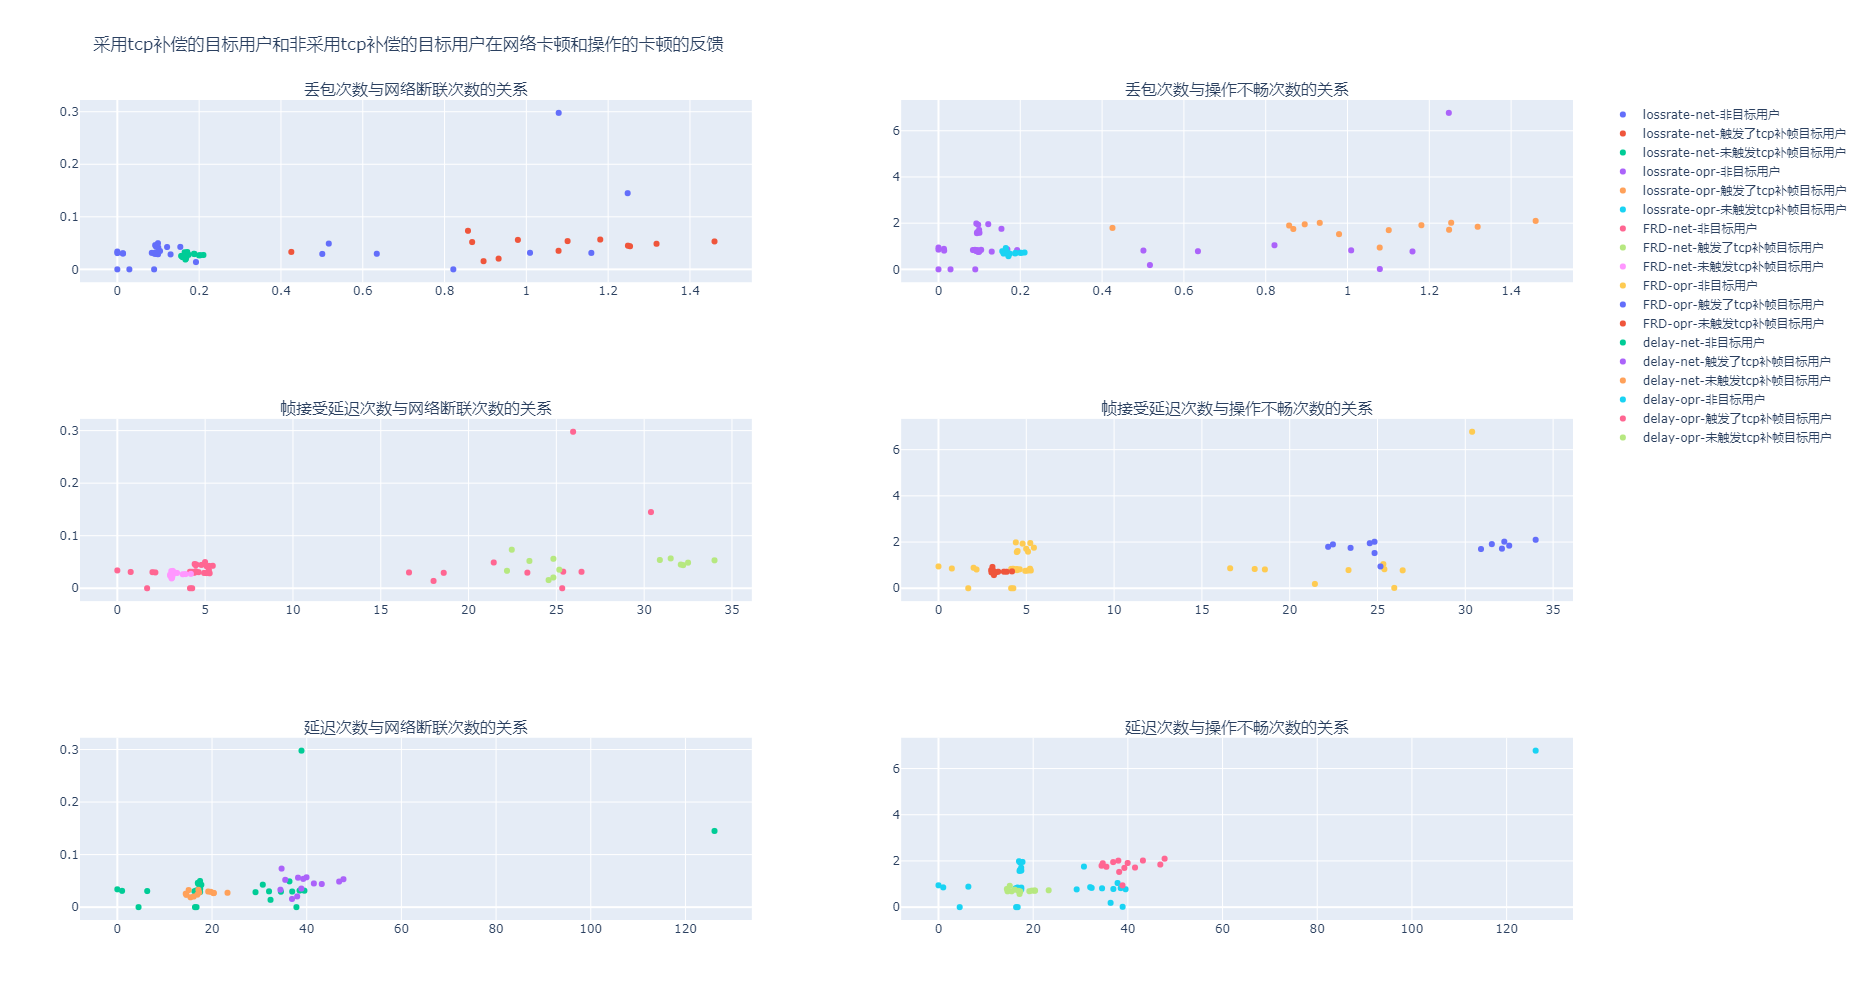

In [243]:
#采用tcp补偿的目标用户和非采用tcp补偿的目标用户在网络卡顿和操作的卡顿的反馈
#图1&2：丢包率在10%-50%时的统计次数和发生网络断联和操作不畅两个指标的次数之间关系
#图3&4：帧接受延迟在200-1500ping时的统计次数和发生网络断联和操作不畅两个指标的次数之间关系
#图5&6：延迟在100-200ping时的统计次数和发生网络断联和操作不畅两个指标的次数之间关系

targetYN=make_subplots(rows=3, cols=2, subplot_titles=['丢包次数与网络断联次数的关系','丢包次数与操作不畅次数的关系','帧接受延迟次数与网络断联次数的关系','帧接受延迟次数与操作不畅次数的关系','延迟次数与网络断联次数的关系','延迟次数与操作不畅次数的关系'])
targetYN.add_trace(go.Scatter(x=nontarget.lossrate.sort_values(),y=nontarget.network_failure,name='lossrate-net-非目标用户',mode='markers'),row=1, col=1)
targetYN.add_trace(go.Scatter(x=target_Y.lossrate.sort_values(),y=target_Y.network_failure,name='lossrate-net-触发了tcp补帧目标用户',mode='markers'),row=1, col=1)
targetYN.add_trace(go.Scatter(x=target_N.lossrate.sort_values(),y=target_N.network_failure,name='lossrate-net-未触发tcp补帧目标用户',mode='markers'),row=1, col=1)

targetYN.add_trace(go.Scatter(x=nontarget.lossrate.sort_values(),y=nontarget.operation_failure,name='lossrate-opr-非目标用户', mode='markers'),row=1, col=2)
targetYN.add_trace(go.Scatter(x=target_Y.lossrate.sort_values(),y=target_Y.operation_failure,name='lossrate-opr-触发了tcp补帧目标用户',mode='markers'),row=1, col=2)
targetYN.add_trace(go.Scatter(x=target_N.lossrate.sort_values(),y=target_N.operation_failure,name='lossrate-opr-未触发tcp补帧目标用户',mode='markers'),row=1, col=2)

targetYN.add_trace(go.Scatter(x=nontarget.FRD.sort_values(),y=nontarget.network_failure,name='FRD-net-非目标用户',mode='markers'),row=2, col=1)
targetYN.add_trace(go.Scatter(x=target_Y.FRD.sort_values(),y=target_Y.network_failure,name='FRD-net-触发了tcp补帧目标用户',mode='markers'),row=2, col=1)
targetYN.add_trace(go.Scatter(x=target_N.FRD.sort_values(),y=target_N.network_failure,name='FRD-net-未触发tcp补帧目标用户',mode='markers'),row=2, col=1)

targetYN.add_trace(go.Scatter(x=nontarget.FRD.sort_values(),y=nontarget.operation_failure,name='FRD-opr-非目标用户', mode='markers'),row=2, col=2)
targetYN.add_trace(go.Scatter(x=target_Y.FRD.sort_values(),y=target_Y.operation_failure,name='FRD-opr-触发了tcp补帧目标用户',mode='markers'),row=2, col=2)
targetYN.add_trace(go.Scatter(x=target_N.FRD.sort_values(),y=target_N.operation_failure,name='FRD-opr-未触发tcp补帧目标用户',mode='markers'),row=2, col=2)

targetYN.add_trace(go.Scatter(x=nontarget.delay.sort_values(),y=nontarget.network_failure,name='delay-net-非目标用户',mode='markers'),row=3, col=1)
targetYN.add_trace(go.Scatter(x=target_Y.delay.sort_values(),y=target_Y.network_failure,name='delay-net-触发了tcp补帧目标用户',mode='markers'),row=3, col=1)
targetYN.add_trace(go.Scatter(x=target_N.delay.sort_values(),y=target_N.network_failure,name='delay-net-未触发tcp补帧目标用户',mode='markers'),row=3, col=1)

targetYN.add_trace(go.Scatter(x=nontarget.delay.sort_values(),y=nontarget.operation_failure,name='delay-opr-非目标用户', mode='markers'),row=3, col=2)
targetYN.add_trace(go.Scatter(x=target_Y.delay.sort_values(),y=target_Y.operation_failure,name='delay-opr-触发了tcp补帧目标用户',mode='markers'),row=3, col=2)
targetYN.add_trace(go.Scatter(x=target_N.delay.sort_values(),y=target_N.operation_failure,name='delay-opr-未触发tcp补帧目标用户',mode='markers'),row=3, col=2)

targetYN=targetYN.update_layout(height=1000, title_text="采用tcp补偿的目标用户和非采用tcp补偿的目标用户在网络卡顿和操作的卡顿的反馈")
targetYN.show()

#非目标用户在一定范围内的丢包、帧接受延迟、延迟次数的游戏体验反而好过成功激发tcp补帧的用户？

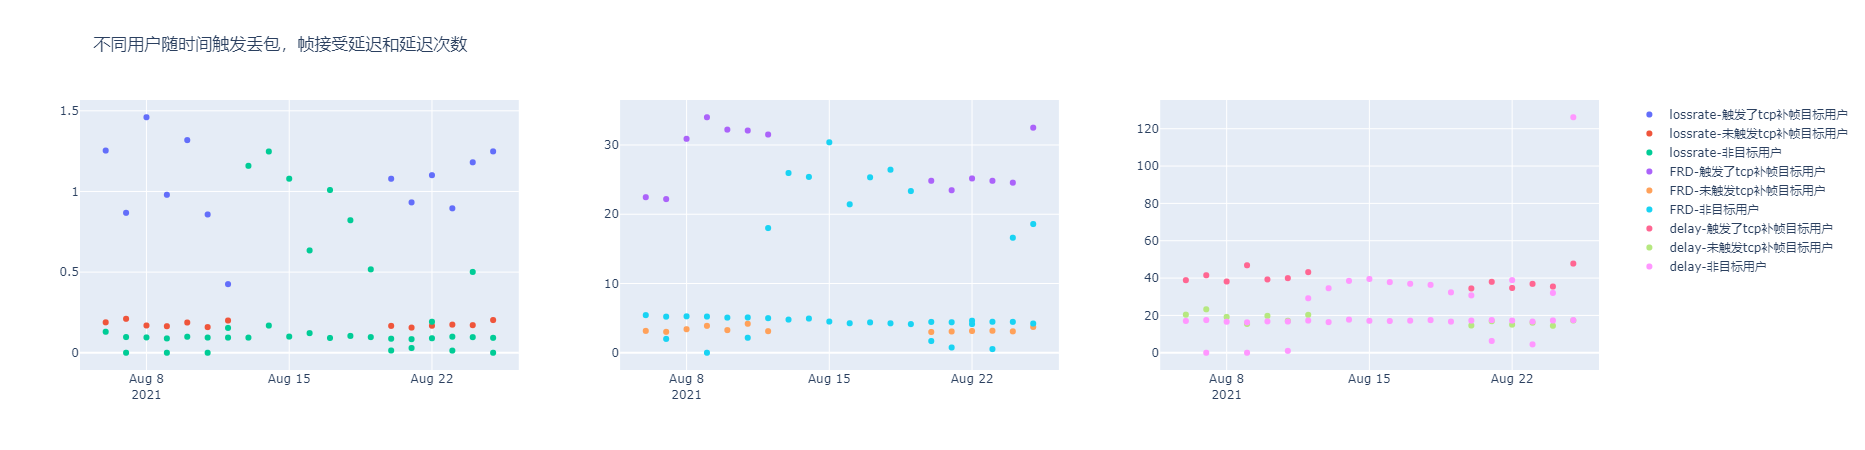

In [245]:
targetdate=make_subplots(rows=1, cols=3)
targetdate.add_trace(go.Scatter(x=target_Y.dtEventTime.sort_values(),y=target_Y.lossrate,name='lossrate-触发了tcp补帧目标用户',mode='markers'),row=1, col=1)
targetdate.add_trace(go.Scatter(x=target_N.dtEventTime.sort_values(),y=target_N.lossrate,name='lossrate-未触发tcp补帧目标用户',mode='markers'),row=1, col=1)
targetdate.add_trace(go.Scatter(x=nontarget.dtEventTime.sort_values(),y=nontarget.lossrate,name='lossrate-非目标用户',mode='markers'),row=1, col=1)

targetdate.add_trace(go.Scatter(x=target_Y.dtEventTime.sort_values(),y=target_Y.FRD,name='FRD-触发了tcp补帧目标用户',mode='markers'),row=1, col=2)
targetdate.add_trace(go.Scatter(x=target_N.dtEventTime.sort_values(),y=target_N.FRD,name='FRD-未触发tcp补帧目标用户',mode='markers'),row=1, col=2)
targetdate.add_trace(go.Scatter(x=nontarget.dtEventTime.sort_values(),y=nontarget.FRD,name='FRD-非目标用户',mode='markers'),row=1, col=2)

targetdate.add_trace(go.Scatter(x=target_Y.dtEventTime.sort_values(),y=target_Y.delay,name='delay-触发了tcp补帧目标用户',mode='markers'),row=1, col=3)
targetdate.add_trace(go.Scatter(x=target_N.dtEventTime.sort_values(),y=target_N.delay,name='delay-未触发tcp补帧目标用户',mode='markers'),row=1, col=3)
targetdate.add_trace(go.Scatter(x=nontarget.dtEventTime.sort_values(),y=nontarget.delay,name='delay-非目标用户',mode='markers'),row=1, col=3)

targetdate=targetdate.update_layout(title_text="不同用户随时间触发丢包，帧接受延迟和延迟次数")
targetdate.show()